# Customer Segmentaion Analysis

This notebook demonstrates multiple customer segmentation techniques using online shopping data

The full dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

In [20]:
#import required libraries
import pandas as pd
import datetime as dt

In [80]:
#upload a random sample of 20% from the original dataset
online = pd.read_csv('online.csv')
online = online.iloc[:,1:]
#convert date from string to a datetime object
online['InvoiceDate'] = online['InvoiceDate'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [81]:
#The dataset shape & head
print(online.shape)
online.head()

(70864, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [82]:
#create additional columns for invoice and cohort months
#first create a function that returns the first day of a month
def get_month(x): return dt.datetime(x.year, x.month, 1)

online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)
grouping = online.groupby('CustomerID')['InvoiceMonth']
online['CohortMonth'] = grouping.transform('min')

online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01


In [83]:
#create a helper function to get the year, month, and day from the date
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    
    return year, month, day

In [84]:
#assign time offset between cohort and invoice dates

invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

online['CohortIndex'] = years_diff * 12 + months_diff + 1 #added 1 to avoid 0 so joining month is 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-01,2011-04-01,7
1,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-01,2011-09-01,3
2,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-01,2011-07-01,1
3,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-01,2011-11-01,1
4,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-01,2011-02-01,4


#### Here we create the cohort pivot table to be able to calculate some metrics

In [85]:
#counth the monthly active customers from each cohort
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                  columns='CohortIndex',
                                  values='CustomerID')

cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,716.0,246.0,221.0,251.0,245.0,285.0,249.0,236.0,240.0,265.0,254.0,348.0,172.0
2011-01-01,332.0,69.0,82.0,81.0,110.0,90.0,82.0,86.0,104.0,102.0,124.0,45.0,NaN
2011-02-01,316.0,58.0,57.0,83.0,85.0,74.0,80.0,83.0,86.0,95.0,28.0,NaN,NaN
2011-03-01,388.0,63.0,100.0,76.0,83.0,67.0,98.0,85.0,107.0,38.0,NaN,NaN,NaN
2011-04-01,255.0,49.0,52.0,49.0,47.0,52.0,56.0,59.0,17.0,NaN,NaN,NaN,NaN
2011-05-01,249.0,40.0,43.0,36.0,52.0,58.0,61.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,207.0,33.0,26.0,41.0,49.0,62.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,173.0,28.0,31.0,38.0,44.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,139.0,30.0,28.0,35.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cohort Metrics

In [86]:
#calculate the retention rate
#first month is 100% by default
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,34.4,30.9,35.1,34.2,39.8,34.8,33.0,33.5,37.0,35.5,48.6,24.0
2011-01-01,100.0,20.8,24.7,24.4,33.1,27.1,24.7,25.9,31.3,30.7,37.3,13.6,NaN
2011-02-01,100.0,18.4,18.0,26.3,26.9,23.4,25.3,26.3,27.2,30.1,8.9,NaN,NaN
2011-03-01,100.0,16.2,25.8,19.6,21.4,17.3,25.3,21.9,27.6,9.8,NaN,NaN,NaN
2011-04-01,100.0,19.2,20.4,19.2,18.4,20.4,22.0,23.1,6.7,NaN,NaN,NaN,NaN
2011-05-01,100.0,16.1,17.3,14.5,20.9,23.3,24.5,8.8,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,15.9,12.6,19.8,23.7,30.0,9.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,16.2,17.9,22.0,25.4,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,21.6,20.1,25.2,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
#calculate hte average quantity for each cohort month
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',
                                    columns='CohortIndex',
                                    values='Quantity')

average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.1,12.3,12.2,13.2,13.7,11.3,10.6,12.8,13.2,13.0,14.5,10.9,13.7
2011-01-01,10.9,10.8,10.0,10.1,14.3,13.2,17.4,16.4,18.7,10.2,10.7,13.2,NaN
2011-02-01,12.1,14.3,10.6,11.5,17.5,12.2,17.3,13.2,13.4,15.9,14.3,NaN,NaN
2011-03-01,9.6,14.2,13.0,10.2,16.1,12.7,11.6,11.5,9.0,9.6,NaN,NaN,NaN
2011-04-01,9.9,11.1,12.4,11.5,11.4,7.7,10.4,9.4,6.6,NaN,NaN,NaN,NaN
2011-05-01,14.1,9.6,15.3,11.6,11.9,8.5,9.8,7.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.6,16.1,18.1,11.2,12.4,7.2,9.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.9,16.4,5.6,10.1,6.2,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.5,7.4,5.5,5.7,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cohort visualization

Heatmaps can go a long way in highlighting areas for further investigation. Here is how it looks

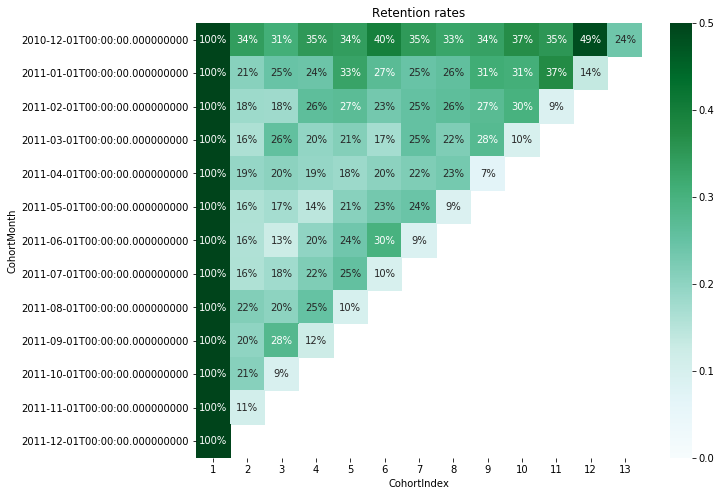

In [88]:
#cohort heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data = retention,
annot = True,
fmt = '.0%',
vmin = 0.0,
vmax = 0.5,
cmap = 'BuGn')

plt.show()

## Recency, Frequency, Monitary Value Segmentation (RFM) 

There are three indicators that differentiates valuable customers from others:

- Recency(R) when was the last purchase as an evidence that the customer is still active
- Frequency (F) how often does the customer buy to demonstrate loyalty
- Monetary Value (M) how much revenue is generated from the customer to capture the gained value

These point together helps in highlighting the purchasing behaviour of customers and enables optimizing and upselling various segments

In [89]:
#use the last day as the most recent day (should be the day of the analysis in pactice)
snapshot_date = max(online['InvoiceDate']) + dt.timedelta(days=1)

In [90]:
#aggregate the data to customer level with RFM
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'})

#rename columns to RFM for convenience
datamart.columns = ['Recency', 'Frequency', 'MonetaryValue']

datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,126.26
12748,1,967,3098.10
12749,4,37,161.75
12820,3,17,33.57
12822,71,9,24.16


### Building RFM Segmentation

Now we have the three metrics for each CustomerID that can be used for segmentation and further analysis

In [91]:
#segment rcency by quartiles to enable comparative analysis
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

In [92]:
#do the same for frequency & monetary value
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12747,2,27,126.26,4,4,4
12748,1,967,3098.10,4,4,4
12749,4,37,161.75,4,4,4
12820,3,17,33.57,4,3,3
12822,71,9,24.16,2,2,2


In [93]:
#the next step is to give each customer an RFM score which can be based on the three values
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

In [94]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,126.26,4,4,4,444,12.0
12748,1,967,3098.10,4,4,4,444,12.0
12749,4,37,161.75,4,4,4,444,12.0
12820,3,17,33.57,4,3,3,433,10.0
12822,71,9,24.16,2,2,2,222,6.0


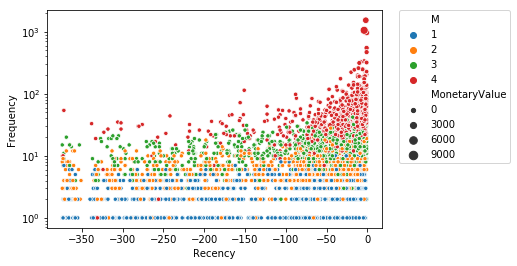

In [95]:
#to build an intuition of the dataset a bubblechart is created
datamart_ = datamart.copy()
datamart_['Recency'] = datamart_['Recency']*-1
sns.scatterplot(data=datamart_, x="Recency", y="Frequency", hue="M", size="MonetaryValue").set(yscale="log")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

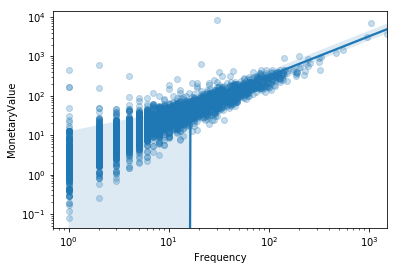

In [96]:
#exploring the correlation between frequency and monetary value 
sns.regplot(x="Frequency", y="MonetaryValue", 
                    data=datamart_, fit_reg=True, scatter_kws={'alpha':0.25}).set(xscale="log", yscale="log")

plt.show()

In [78]:
#grouping customers into named segments for clarity of insights
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'


datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({'Recency': 'mean'
,'Frequency': 'mean'
,'MonetaryValue': ['mean'
,'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            209.0       2.3           6.5   734
Gold               29.9      40.4         123.8  1419
Silver             99.0       7.6          23.6  1548

## K-means clustering

In [100]:
#k-means clustering expects an equal mean and std between veriables 
#so preprocessing is required to standardize RFM
from sklearn.preprocessing import StandardScaler
import numpy as np
#log transformation
datamart_rfm = datamart.iloc[:,:3].copy()
datamart_log = np.log(datamart_rfm)
#scaling
scaler = StandardScaler()
scaler.fit(datamart_log)
datamart_normalized = scaler.transform(datamart_log)

print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [ 0.  0. -0.]
std:  [1. 1. 1.]


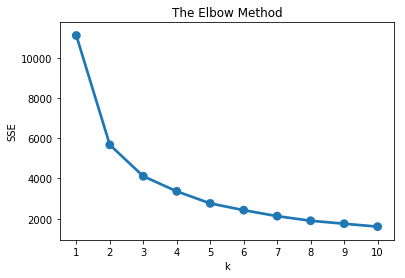

In [102]:
#we use the eblow method to select the optimal cluster number
# Import key libraries
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_
    
# sum of squared distances to closest cluster center
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [103]:
#3 clusters is selected
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(datamart_normalized)
cluster_labels = kmeans.labels_

#add cluster label to original dataset
datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels)

In [106]:
# Calculate average RFM values and size for each cluster
datamart_rfm_k3.groupby(['Cluster']).agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean','count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         156.0       2.0           6.0  1059
1          17.0      48.0         148.0  1034
2         104.0      11.0          35.0  1608

In [107]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg / population_avg - 1

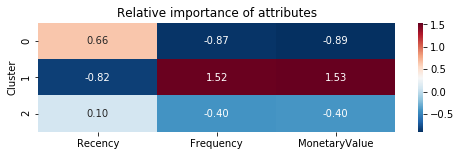

In [115]:
# Plot heatmap
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdBu_r')
plt.show()

## Conclusion & Actionable Insights

broadly speaking, there are 3 customer segments:

- Cluster 1: Very recent & frequent high value purchase customers (Top tier)
- Cluster 0: Few old purchases of low value (one-offs and churns)
- Cluster 2: Recent purchases with low-mid value purchases (likely to be new joiners)

Each of theses segments can now be targeted with marketing emails, offers, and rewards that encourages further spending. However, this analysis is a starting point that can be supplimented with purchase history to identify complementary sales opportunities.